In [1]:
###############################################
# 1) IMPORT LIBRARIES & SET PATHS
###############################################
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path


PREPROCESS_ROOT = "/kaggle/input/my-preprocessed-data/preprocessed"

CHECKPOINT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Using dataset at:", PREPROCESS_ROOT)
print("Saving models to:", CHECKPOINT_DIR)


Using dataset at: /kaggle/input/my-preprocessed-data/preprocessed
Saving models to: /kaggle/working/checkpoints


In [3]:
###############################################
# 2) DATASET CLASS
###############################################
class PTDataset(Dataset):
    def __init__(self, imgs, gts):
        self.imgs = imgs
        self.gts = gts

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = torch.load(self.imgs[idx]).float()
        gt  = torch.load(self.gts[idx]).float()

        if img.ndim == 2: img = img.unsqueeze(0)
        if gt.ndim == 2:  gt = gt.unsqueeze(0)

        return img, gt


In [4]:
###############################################
# 3) LOAD TRAIN / VAL DATA  + VERIFY COUNTS
###############################################
from pathlib import Path

# Correct TrainA paths
train_img_dir = f"{PREPROCESS_ROOT}/TrainA/images"
train_gt_dir  = f"{PREPROCESS_ROOT}/TrainA/gt"

# List .pt files
train_imgs = sorted([str(p) for p in Path(train_img_dir).glob("*.pt")])
train_gts  = sorted([str(p) for p in Path(train_gt_dir).glob("*.pt")])

# Verify counts
print("Total image files in TrainA:", len(train_imgs))
print("Total GT files in TrainA   :", len(train_gts))

# Sanity check
if len(train_imgs) != len(train_gts):
    print("WARNING: Image/GT count mismatch!")

# 10% validation split
num = len(train_imgs)
val_num = num // 10
print("Validation size:", val_num)

train_imgs_split = train_imgs[:-val_num]
train_gts_split  = train_gts[:-val_num]
val_imgs_split   = train_imgs[-val_num:]
val_gts_split    = train_gts[-val_num:]

# Create datasets
train_ds = PTDataset(train_imgs_split, train_gts_split)
val_ds   = PTDataset(val_imgs_split, val_gts_split)

print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))

# Read GT size for CSRNet wrapper
_, sample_gt = train_ds[0]
GT_H, GT_W = sample_gt.shape[-2], sample_gt.shape[-1]
print("GT shape detected:", GT_H, "x", GT_W)


Total image files in TrainA: 300
Total GT files in TrainA   : 300
Validation size: 30
Training samples: 270
Validation samples: 30
GT shape detected: 64 x 64


In [5]:
###############################################
# 4) DATALOADERS + CSRNET MODEL
###############################################
# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

# CSRNET MODEL 
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])
        self.backend = nn.Sequential(
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,256,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(256,128,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(128,64,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# Wrapper to match GT size
class CSRNetWrapper(nn.Module):
    def __init__(self, core, h, w):
        super().__init__()
        self.core = core
        self.h, self.w = h, w

    def forward(self, x):
        out = self.core(x)
        if out.shape[-2:] != (self.h, self.w):
            out = F.interpolate(out, size=(self.h, self.w), mode='bilinear', align_corners=False)
        return out

model = CSRNetWrapper(CSRNet(), GT_H, GT_W).cuda()
print("Model loaded.")


Train batches: 34
Val batches: 4


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 239MB/s] 


Model loaded.


In [6]:
###############################################
# 5) OPTIMIZER & LOSS
###############################################
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

NUM_EPOCHS = 100
best_val_loss = float("inf")

print("Training for", NUM_EPOCHS, "epochs...")


Training for 100 epochs...


In [7]:
###############################################
# 6) TRAINING LOOP (100 EPOCHS)
###############################################
for epoch in range(1, NUM_EPOCHS+1):

    # TRAIN
    model.train()
    train_loss = 0
    for imgs, gts in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        imgs, gts = imgs.cuda(), gts.cuda()
        preds = model(imgs)
        loss = criterion(preds, gts)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    # VALIDATION
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, gts in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
            imgs, gts = imgs.cuda(), gts.cuda()
            preds = model(imgs)
            val_loss += criterion(preds, gts).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch}: Train={train_loss:.6f}  Val={val_loss:.6f}")

    # Save every 20 epochs
    if epoch % 20 == 0:
        ckpt_path = f"{CHECKPOINT_DIR}/checkpoint_epoch{epoch}.pth"
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict()}, ckpt_path)
        print("Saved:", ckpt_path)

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_path = f"{CHECKPOINT_DIR}/best_model.pth"
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict()}, best_path)
        print("BEST model saved:", best_path)

# Save final model
final_path = f"{CHECKPOINT_DIR}/final_epoch100.pth"
torch.save({"epoch": 100, "model_state": model.state_dict()}, final_path)
print("FINAL model saved:", final_path)


Epoch 1 Val: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 1: Train=0.104159  Val=0.083514
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 2 Val: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch 2: Train=0.062771  Val=0.053801
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 3 Val: 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


Epoch 3: Train=0.054753  Val=0.054365


Epoch 4 Val: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 4: Train=0.044910  Val=0.047418
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 5 Val: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch 5: Train=0.041203  Val=0.046828
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 6 Val: 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 6: Train=0.037640  Val=0.044792
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 7 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 7: Train=0.034996  Val=0.044547
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 8 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 8: Train=0.035113  Val=0.044831


Epoch 9 Val: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 9: Train=0.032780  Val=0.040208
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 10 Val: 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


Epoch 10: Train=0.032020  Val=0.045596


Epoch 11 Val: 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 11: Train=0.029349  Val=0.042860


Epoch 12 Val: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch 12: Train=0.027694  Val=0.040832


Epoch 13 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 13: Train=0.029992  Val=0.045349


Epoch 14 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 14: Train=0.028586  Val=0.041716


Epoch 15 Val: 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch 15: Train=0.026662  Val=0.038307
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 16 Val: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 16: Train=0.025353  Val=0.043243


Epoch 17 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 17: Train=0.024029  Val=0.040619


Epoch 18 Val: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch 18: Train=0.022802  Val=0.037867
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 19 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 19: Train=0.024175  Val=0.038756


Epoch 20 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 20: Train=0.022557  Val=0.040410
Saved: /kaggle/working/checkpoints/checkpoint_epoch20.pth


Epoch 21 Val: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 21: Train=0.021771  Val=0.046174


Epoch 22 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 22: Train=0.022901  Val=0.042654


Epoch 23 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 23: Train=0.023087  Val=0.038919


Epoch 24 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 24: Train=0.023033  Val=0.042031


Epoch 25 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 25: Train=0.021001  Val=0.045452


Epoch 26 Val: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 26: Train=0.020138  Val=0.043921


Epoch 27 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 27: Train=0.019580  Val=0.043626


Epoch 28 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 28: Train=0.019416  Val=0.043965


Epoch 29 Val: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 29: Train=0.018947  Val=0.043191


Epoch 30 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 30: Train=0.018542  Val=0.044805


Epoch 31 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 31: Train=0.018782  Val=0.043814


Epoch 32 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 32: Train=0.019472  Val=0.042019


Epoch 33 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 33: Train=0.017980  Val=0.045923


Epoch 34 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 34: Train=0.017697  Val=0.045444


Epoch 35 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 35: Train=0.017727  Val=0.048800


Epoch 36 Val: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 36: Train=0.017316  Val=0.046318


Epoch 37 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 37: Train=0.017919  Val=0.050764


Epoch 38 Val: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 38: Train=0.017540  Val=0.052923


Epoch 39 Val: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch 39: Train=0.017181  Val=0.043748


Epoch 40 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 40: Train=0.017125  Val=0.047089
Saved: /kaggle/working/checkpoints/checkpoint_epoch40.pth


Epoch 41 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 41: Train=0.016140  Val=0.048095


Epoch 42 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 42: Train=0.016137  Val=0.044307


Epoch 43 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 43: Train=0.016958  Val=0.051222


Epoch 44 Val: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 44: Train=0.020031  Val=0.050061


Epoch 45 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 45: Train=0.017375  Val=0.043427


Epoch 46 Val: 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


Epoch 46: Train=0.016184  Val=0.043100


Epoch 47 Val: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 47: Train=0.015223  Val=0.045318


Epoch 48 Val: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 48: Train=0.015034  Val=0.042958


Epoch 49 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 49: Train=0.014955  Val=0.049207


Epoch 50 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 50: Train=0.015065  Val=0.049406


Epoch 51 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 51: Train=0.015007  Val=0.048224


Epoch 52 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 52: Train=0.014481  Val=0.048646


Epoch 53 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 53: Train=0.014330  Val=0.045213


Epoch 54 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 54: Train=0.014135  Val=0.049009


Epoch 55 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 55: Train=0.014469  Val=0.047073


Epoch 56 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 56: Train=0.014470  Val=0.044998


Epoch 57 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 57: Train=0.014341  Val=0.050466


Epoch 58 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 58: Train=0.015901  Val=0.048529


Epoch 59 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 59: Train=0.014045  Val=0.049192


Epoch 60 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 60: Train=0.013179  Val=0.045561
Saved: /kaggle/working/checkpoints/checkpoint_epoch60.pth


Epoch 61 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 61: Train=0.013156  Val=0.045285


Epoch 62 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 62: Train=0.013207  Val=0.049334


Epoch 63 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 63: Train=0.012806  Val=0.048430


Epoch 64 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 64: Train=0.012632  Val=0.051092


Epoch 65 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 65: Train=0.013249  Val=0.044504


Epoch 66 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 66: Train=0.012959  Val=0.046051


Epoch 67 Val: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 67: Train=0.012405  Val=0.051779


Epoch 68 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 68: Train=0.012446  Val=0.051608


Epoch 69 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 69: Train=0.012701  Val=0.049717


Epoch 70 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 70: Train=0.013213  Val=0.049557


Epoch 71 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 71: Train=0.014159  Val=0.042525


Epoch 72 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 72: Train=0.012999  Val=0.045306


Epoch 73 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 73: Train=0.012199  Val=0.048805


Epoch 74 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 74: Train=0.011585  Val=0.046275


Epoch 75 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 75: Train=0.011382  Val=0.045696


Epoch 76 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 76: Train=0.011277  Val=0.053582


Epoch 77 Val: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 77: Train=0.011651  Val=0.047745


Epoch 78 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 78: Train=0.011080  Val=0.045735


Epoch 79 Val: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 79: Train=0.010847  Val=0.046308


Epoch 80 Val: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 80: Train=0.011426  Val=0.047099
Saved: /kaggle/working/checkpoints/checkpoint_epoch80.pth


Epoch 81 Val: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 81: Train=0.011530  Val=0.046934


Epoch 82 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 82: Train=0.010990  Val=0.048114


Epoch 83 Val: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 83: Train=0.010832  Val=0.048665


Epoch 84 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 84: Train=0.010472  Val=0.045335


Epoch 85 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 85: Train=0.010433  Val=0.047360


Epoch 86 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 86: Train=0.010169  Val=0.046908


Epoch 87 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 87: Train=0.010004  Val=0.047882


Epoch 88 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 88: Train=0.009948  Val=0.050458


Epoch 89 Val: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 89: Train=0.009947  Val=0.044711


Epoch 90 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 90: Train=0.011256  Val=0.043496


Epoch 91 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 91: Train=0.014080  Val=0.051682


Epoch 92 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 92: Train=0.012442  Val=0.044068


Epoch 93 Val: 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch 93: Train=0.010802  Val=0.044659


Epoch 94 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 94: Train=0.009870  Val=0.051114


Epoch 95 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 95: Train=0.009645  Val=0.046085


Epoch 96 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 96: Train=0.009265  Val=0.047510


Epoch 97 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 97: Train=0.009083  Val=0.045656


Epoch 98 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 98: Train=0.008998  Val=0.048691


Epoch 99 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 99: Train=0.009006  Val=0.045813


Epoch 100 Val: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch 100: Train=0.009023  Val=0.048604
Saved: /kaggle/working/checkpoints/checkpoint_epoch100.pth
FINAL model saved: /kaggle/working/checkpoints/final_epoch100.pth


In [8]:
###############################################
# 7) TESTING
###############################################
test_img_dir = "/kaggle/input/my-preprocessed-data/preprocessed/TestA/images"
test_gt_dir  = "/kaggle/input/my-preprocessed-data/preprocessed/TestA/gt"

test_imgs = sorted([str(p) for p in Path(test_img_dir).glob("*.pt")])
test_gts  = sorted([str(p) for p in Path(test_gt_dir).glob("*.pt")])

test_ds = PTDataset(test_imgs, test_gts)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

abs_errs = []
sq_errs  = []
acc_list = []
pix_mae_list = []
pix_mse_list = []

model.eval()
with torch.no_grad():
    for imgs, gts in tqdm(test_loader, desc="Testing"):
        imgs, gts = imgs.cuda(), gts.cuda()
        preds = model(imgs)

        # pixel errors
        mae = torch.abs(preds-gts).mean(dim=[1,2,3]).cpu().numpy()
        mse = ((preds-gts)**2).mean(dim=[1,2,3]).cpu().numpy()
        pix_mae_list.extend(mae)
        pix_mse_list.extend(mse)

        # count errors
        pc = preds.sum(dim=[1,2,3]).cpu().numpy()
        gc = gts.sum(dim=[1,2,3]).cpu().numpy()

        for p, g in zip(pc, gc):
            abs_errs.append(abs(p-g))
            sq_errs.append((p-g)**2)

            if g > 0:
                acc = max(0, 1 - abs(p-g)/g)
            else:
                acc = 1 if p < 1e-6 else 0

            acc_list.append(acc)

print("\n=== TEST RESULTS ===")
print("Pixel MAE:", float(np.mean(pix_mae_list)))
print("Pixel RMSE:", float(np.sqrt(np.mean(pix_mse_list))))
print("Count MAE:", float(np.mean(abs_errs)))
print("Count RMSE:", float(np.sqrt(np.mean(sq_errs))))
print("Counting Accuracy:", float(np.mean(acc_list))*100, "%")


Testing: 100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


=== TEST RESULTS ===
Pixel MAE: 0.07172419130802155
Pixel RMSE: 0.15949875116348267
Count MAE: 79.48896026611328
Count RMSE: 119.56171539391818
Counting Accuracy: 79.1317360621661 %


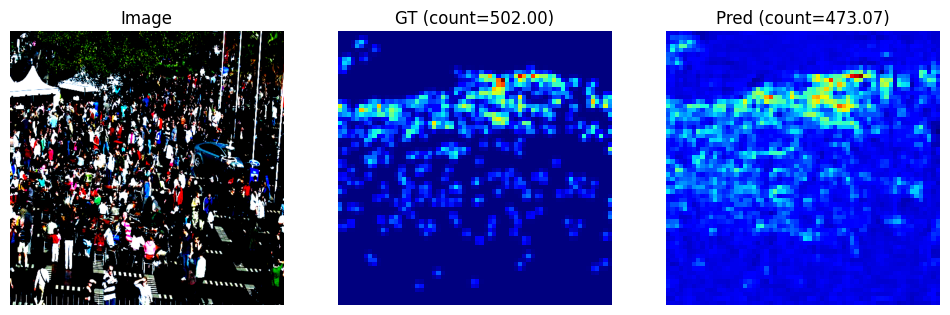

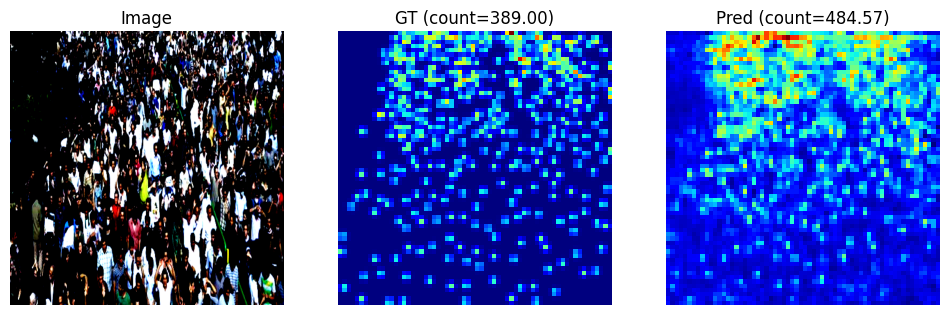

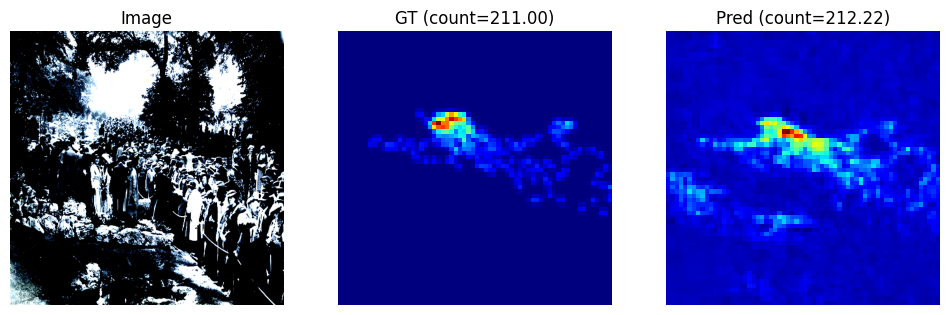

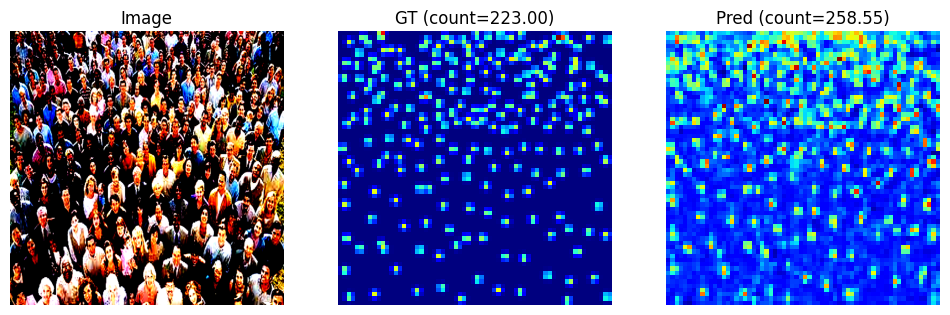

In [13]:
###############################################
# 8) VISUALIZE 4 SAMPLES
###############################################

def show_map(img, gt, pred):
    # Convert image tensor to numpy
    img = img.permute(1,2,0).cpu().numpy()
    img = np.clip(img, 0, 1)

    # Convert GT & prediction to numpy
    gt_map = gt.squeeze().cpu().numpy()
    pr_map = pred.squeeze().cpu().numpy()

    # Plot
    plt.figure(figsize=(12,4))

    # Original image
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    # GT density
    plt.subplot(1,3,2)
    plt.imshow(gt_map, cmap="jet")
    plt.axis("off")
    plt.title(f"GT (count={gt_map.sum():.2f})")

    # Predicted density
    plt.subplot(1,3,3)
    plt.imshow(pr_map, cmap="jet")
    plt.axis("off")
    plt.title(f"Pred (count={pr_map.sum():.2f})")

    plt.show()


# ---- RUN VISUALIZATION FOR 4 SAMPLES ----
for i in range(4):
    img, gt = test_ds[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).cuda())[0].cpu()
    show_map(img, gt, pred)
